In [1]:
# Anthony J. Guarino: Spectral Emissions Distribution Sub Analysis (ARP 220)

In [2]:
# Import libraries
import csv
from os import listdir
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
import emcee
import corner
plt.ion()
plt.rcParams.update({'font.size': 16, 'text.usetex': True})


In [3]:
# constants

h = 6.626e-34 #[J*s]
k = 1.381e-23 #[J/K]

DATA_PATH="data\\formatted_data.json"


In [4]:
# properly formatting and defining a function to search through the data

path = "data\\"

files = listdir(path + 'raw\\') # lists all the file names in the 'path' directory
num_files = len(files) # stores the number of files in the 'path' directory

floats = ["Photometry Measurement", "Frequency", "Flux Density", "Upper limit of uncertainty", 'Lower limit of uncertainty']
ints = ["No."]
def return_csv(file):
    csv_dict = {}
    with open(file) as csv_file:
        csv_read = csv.reader(csv_file)

        i = 0
        for line in csv_read:
            if i == 0:
                # Initialize csv dictionary with header values as keys
                for key in line:
                    csv_dict[key] = []
                i += 1
                continue
            
            # Add the value in the csv to the corresponding key
            index = 0
            for key in csv_dict:
                if line[index] == "":
                    line[index] = None
                if key in floats and line[index] != None:
                    line[index] = float(line[index])
                if key in ints and line[index] != None:
                    line[index] = int(line[index])

                csv_dict[key].append(line[index])
                index+=1
            i +=1

    return csv_dict


data = {}

for file in files:
    name = file.replace('_Photometry_and_SED.csv', '')
    print(name)
    data[name] = return_csv(path + 'raw\\' + file)


with open(path + 'formatted_data.json', 'w') as f:
    json.dump(data, f, indent=2)



with open(DATA_PATH) as f:
    data = json.load(f)
    
keys = data.keys()
fields = None

print("Galaxies:")
for i in keys:
    fields = data[i].keys()
    print("\t- {} ({} datapoints across {} fields)".format(i, len(data[i]['No.']), len(data[i])))
    
print("\nField List:")
print(fields)

# Returns all the data associated with a given set of number keys

def get_in_key(key, numbers):
    _ret = {"flux_density":[],"frequency":[],"uncertainty":[]}
    _not_added = []
    search = data[key]['No.']
    indices = []
    for i in numbers:
        found  = 0
        for j in range(len(search)-1,-1,-1):
            if search[j] == i and not found:
                _ret["flux_density"].append(data[key]['Flux Density'][j])
                _ret["frequency"].append(data[key]['Frequency'][j])
                _ret["uncertainty"].append(data[key]['Upper limit of uncertainty'][j])
                found = 1
        if not found:
            _not_added.append(i)

    return _ret, _not_added

APM08279+5255
ARP220
NGC0958
Galaxies:
	- APM08279+5255 (50 datapoints across 21 fields)
	- ARP220 (270 datapoints across 21 fields)
	- NGC0958 (80 datapoints across 21 fields)

Field List:
dict_keys(['No.', 'Observed Passband', 'Photometry Measurement', 'Uncertainty', 'Units', 'Frequency', 'Flux Density', 'Upper limit of uncertainty', 'Lower limit of uncertainty', 'Upper limit of Flux Density', 'Lower limit of Flux Density', 'NED Uncertainty', 'NED Units', 'Refcode', 'Significance', 'Published frequency', 'Frequency Mode', 'Coordinates Targeted', 'Spatial Mode', 'Qualifiers', 'Comments'])


In [5]:
# functions

def limit(nu, T, alpha, beta):
    return 3 + beta - ((10**nu)*h/(k*T))*np.exp(h*(10**nu)/(k*T))/(np.exp(h*(10**nu)/(k*T))-1) + alpha

def model1(freq, fit):
    L, T, alpha, beta = fit
    nu_prime = optimize.newton(limit, 13, args=(T, alpha, beta))
    L1 = ((10**L)*(10**nu_prime)**(3+beta)/(np.exp(h*(10**nu_prime)/(k*T))-1)/((10**nu_prime)**(-1*alpha)))
    predictions = []
    
    for nu in freq:
        if (nu < 10**nu_prime):
            predictions.append( 1e-26*(10**L)*(nu**(3+beta))/(np.exp(h*nu/(k*T))-1) )
        else:
            predictions.append( 1e-26*L1*(nu**(-1*alpha)) )
    return predictions

def penalty(param, freq, flux, error):
    return np.sum((model1(freq, param)-flux)**2/error**2)

def lnprob(param, freq, flux, error):
     return -0.5*penalty(param, freq, flux, error)

# Original Datapoints as used in Blain et. al

<ipython-input-6-9764b6cd85e8>:22: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


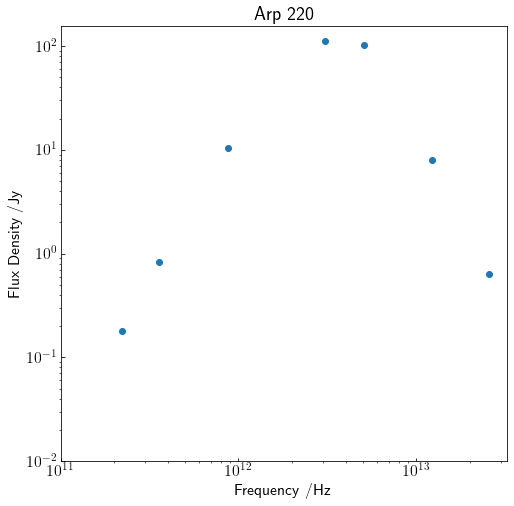

In [6]:
f_ARP220_list, omitted_numbers_2 = get_in_key('ARP220', [284, 245, 221, 196, 189, 174, 134])

frequencies_Arp = np.array(f_ARP220_list["frequency"])
flux_densities_Arp = np.array(f_ARP220_list["flux_density"])
errors_Arp = np.array(f_ARP220_list["uncertainty"])

# Accounting for redshift
frequencies_Arp = (1 + 0.018)*np.array(frequencies_Arp)


f, ax = plt.subplots(1, figsize=(8,8))
ax.plot(frequencies_Arp, flux_densities_Arp, 'o')
ax.set_xscale('log')
ax.set_xticks([1e+11, 1e+12, 1e+13])
ax.set_yscale('log')
ax.set_yticks([0.01, 0.1, 1, 10, 100])
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
ax.set_title('Arp 220')
ax.set_ylabel('Flux Density /Jy')
ax.set_xlabel('Frequency /Hz')
f.show()

Optimization terminated successfully.
         Current function value: 1.617711
         Iterations: 458
         Function evaluations: 772
[-22.04973201  45.95683223   3.38279048   1.12131049]


<ipython-input-7-4b606c2eca43>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


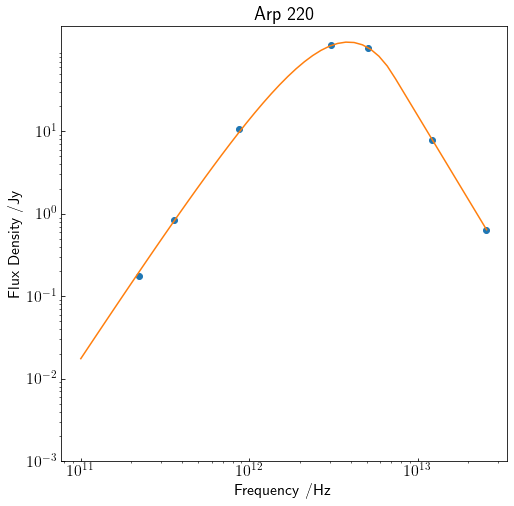

In [7]:
# fit for Arp 220
fit2 = optimize.fmin(penalty, [-31, 37.4, 2.9, 1.5], args=(frequencies_Arp, flux_densities_Arp, errors_Arp))
arp_fit = model1(frequencies_Arp, fit2)
print (fit2)

#plot fit for Arp 220
x = np.logspace(11,13.41000)

f, ax = plt.subplots(1, figsize=(8,8))
ax.plot(frequencies_Arp, flux_densities_Arp, 'o')
ax.plot(x, model1(x,fit2))
ax.set_xscale('log')
ax.set_xticks([1e+11, 1e+12, 1e+13])
ax.set_yscale('log')
ax.set_yticks([0.001, 0.01, 0.1, 1, 10])
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
ax.set_title('Arp 220')
ax.set_ylabel('Flux Density /Jy')
ax.set_xlabel('Frequency /Hz')
f.show()

<ipython-input-8-d1bb96ee9053>:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
<ipython-input-8-d1bb96ee9053>:40: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


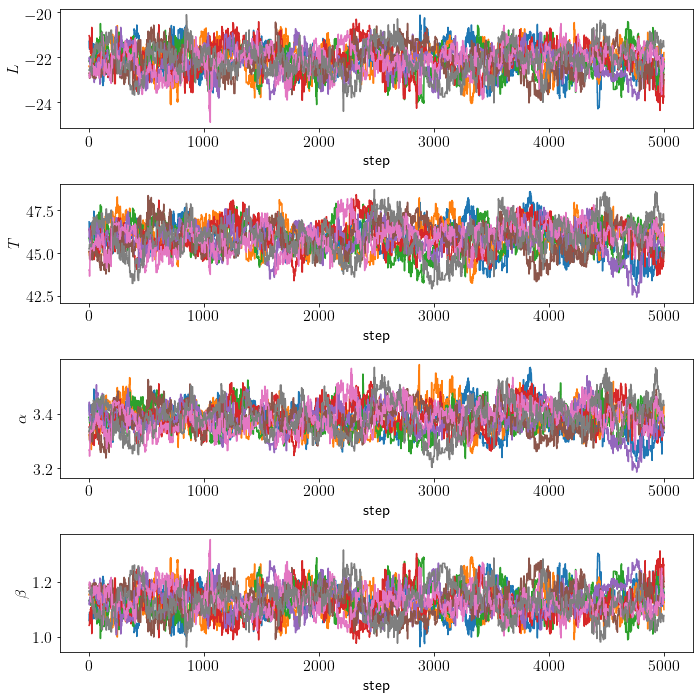

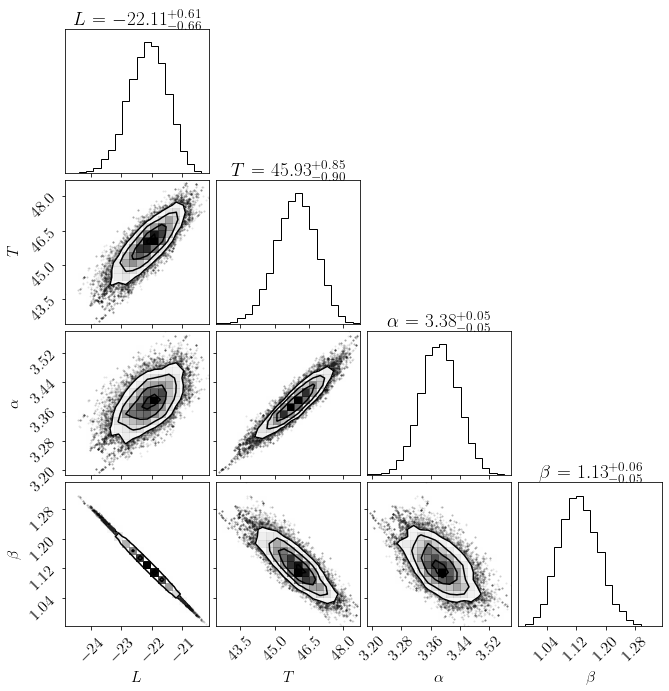

In [8]:
# Emcee run for Arp 220 model

ndim = 4
nwalk = ndim*2
nburn = 1000
nmain = 5000

# Random starting points
p0 = np.zeros((nwalk, ndim))
for i in range(nwalk):
    p0[i] = fit2 + np.random.uniform(low=-0.05, high=0.05, size=4)

    
sampler = emcee.EnsembleSampler(nwalk, ndim, lnprob, args=(frequencies_Arp, flux_densities_Arp, errors_Arp))

# Burn-in run
pos,prob,state = sampler.run_mcmc(p0, nburn)

sampler.reset()

# Main run
res = sampler.run_mcmc(pos, nmain)
samples = sampler.chain.reshape((-1,ndim))

# plot the individual parameters for model
f, ax = plt.subplots(ndim, 1, figsize=(10, 10))
for idim in range(ndim):
    for iwalk in range(nwalk):
        ax[idim].plot(sampler.chain[iwalk,:,idim])
    ax[idim].set_xlabel('step')
ax[0].set_ylabel(r'$L$')
ax[1].set_ylabel(r'$T$')
ax[2].set_ylabel(r'$\alpha$')
ax[3].set_ylabel(r'$\beta$')
f.tight_layout()
f.show()

# Plot corner plot
f = corner.corner(samples, show_titles=True, labels=(r'$L$', r'$T$', r'$\alpha$', r'$\beta$'))
f.show()

# New Dataset: Alternative Infrared

In [9]:
f_ARP220_list, omitted_numbers_2 = get_in_key('ARP220', [263, 244, 198, 187, 116, 60, 45])

frequencies_Arp = np.array(f_ARP220_list["frequency"])
flux_densities_Arp = np.array(f_ARP220_list["flux_density"])
errors_Arp = np.array(f_ARP220_list["uncertainty"])

freq_range = (np.max(frequencies_Arp), np.min(frequencies_Arp))
flux_range = (np.max(flux_densities_Arp), np.min(flux_densities_Arp))

x_ticks = np.linspace(*freq_range, 4)
y_ticks = np.linspace(*flux_range, 4)

print(frequencies_Arp)
print(flux_densities_Arp)
print(errors_Arp)

# Accounting for redshift
frequencies_Arp = (1 + 0.018)*np.array(frequencies_Arp)

[2.40e+11 3.53e+11 2.52e+12 5.00e+12 3.75e+13 2.40e+14 4.57e+14]
[2.26e-01 4.56e-01 1.17e+02 1.04e+02 3.86e-03 5.22e-02 4.46e-02]
[0.01     0.0469   0.2      0.112    0.000401 0.000922 0.00669 ]


Optimization terminated successfully.
         Current function value: 3286.270081
         Iterations: 306
         Function evaluations: 503
[-26.5100966   38.23129267   5.49466092   1.50947477]


<ipython-input-10-bff63a2b949b>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


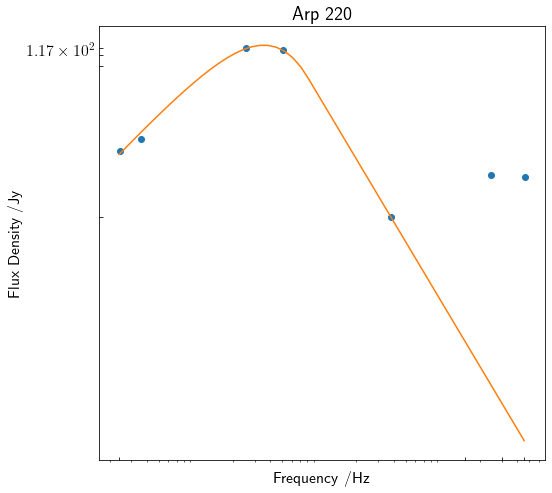

In [10]:
# Optimization
fit2 = optimize.fmin(penalty, [-31, 37.4, 2.9, 1.5], args=(frequencies_Arp, flux_densities_Arp, errors_Arp))
arp_fit = model1(frequencies_Arp, fit2)
print (fit2)

# Plotting:
x = np.logspace(np.log10(freq_range[0]),np.log10(freq_range[1]))

f, ax = plt.subplots(1, figsize=(8,8))
ax.plot(frequencies_Arp, flux_densities_Arp, 'o')
ax.plot(x, model1(x,fit2))
ax.set_xscale('log')
ax.set_xticks()
ax.set_yscale('log')
ax.set_yticks(np.linspace(*flux_range, 4))
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
ax.set_title('Arp 220')
ax.set_ylabel('Flux Density /Jy')
ax.set_xlabel('Frequency /Hz')
f.show()

<ipython-input-11-d1bb96ee9053>:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()
<ipython-input-11-d1bb96ee9053>:40: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


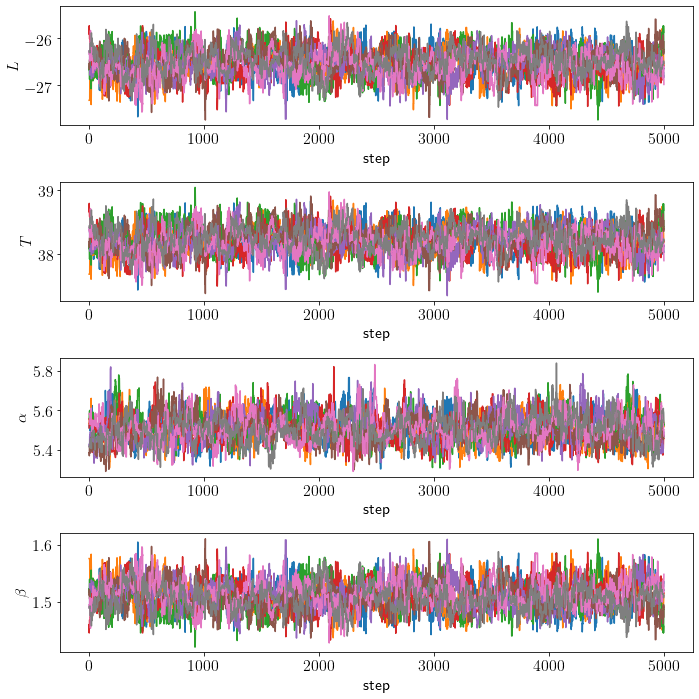

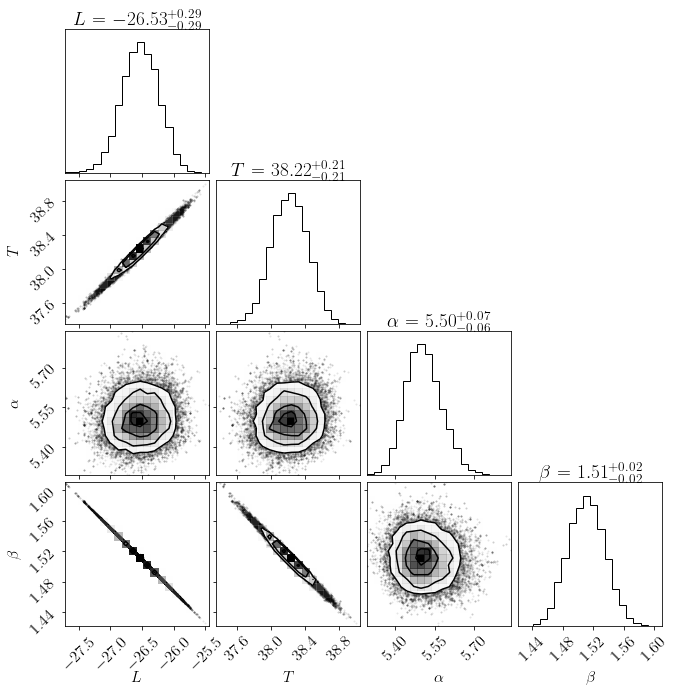

In [11]:
# Emcee run for Arp 220 model

ndim = 4
nwalk = ndim*2
nburn = 1000
nmain = 5000

# Random starting points
p0 = np.zeros((nwalk, ndim))
for i in range(nwalk):
    p0[i] = fit2 + np.random.uniform(low=-0.05, high=0.05, size=4)

    
sampler = emcee.EnsembleSampler(nwalk, ndim, lnprob, args=(frequencies_Arp, flux_densities_Arp, errors_Arp))

# Burn-in run
pos,prob,state = sampler.run_mcmc(p0, nburn)

sampler.reset()

# Main run
res = sampler.run_mcmc(pos, nmain)
samples = sampler.chain.reshape((-1,ndim))

# plot the individual parameters for model
f, ax = plt.subplots(ndim, 1, figsize=(10, 10))
for idim in range(ndim):
    for iwalk in range(nwalk):
        ax[idim].plot(sampler.chain[iwalk,:,idim])
    ax[idim].set_xlabel('step')
ax[0].set_ylabel(r'$L$')
ax[1].set_ylabel(r'$T$')
ax[2].set_ylabel(r'$\alpha$')
ax[3].set_ylabel(r'$\beta$')
f.tight_layout()
f.show()

# Plot corner plot
f = corner.corner(samples, show_titles=True, labels=(r'$L$', r'$T$', r'$\alpha$', r'$\beta$'))
f.show()

# New Dataset: Higher Infrared (Visible Light/UV)

In [12]:
f_ARP220_list, omitted_numbers_2 = get_in_key('ARP220', [113, 90, 70, 57, 41, 26, 20])

frequencies_Arp = np.array(f_ARP220_list["frequency"])
flux_densities_Arp = np.array(f_ARP220_list["flux_density"])
errors_Arp = np.array(f_ARP220_list["uncertainty"])

freq_range = (np.max(frequencies_Arp), np.min(frequencies_Arp))
flux_range = (np.max(flux_densities_Arp), np.min(flux_densities_Arp))

print(frequencies_Arp)
print(flux_densities_Arp)
print(errors_Arp)

# Accounting for redshift
frequencies_Arp = (1 + 0.018)*np.array(frequencies_Arp)

[3.82e+13 8.46e+13 1.82e+14 2.43e+14 4.86e+14 6.81e+14 8.19e+14]
[0.314   0.0453  0.0772  0.0612  0.02    0.0074  0.00355]
[0.0289   0.00417  0.00202  0.00282  0.000922 0.0033   0.000509]


Optimization terminated successfully.
         Current function value: 681.870627
         Iterations: 113
         Function evaluations: 209
[-49.07154705  60.48494162   1.0516693    3.0378281 ]


<ipython-input-13-bff63a2b949b>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


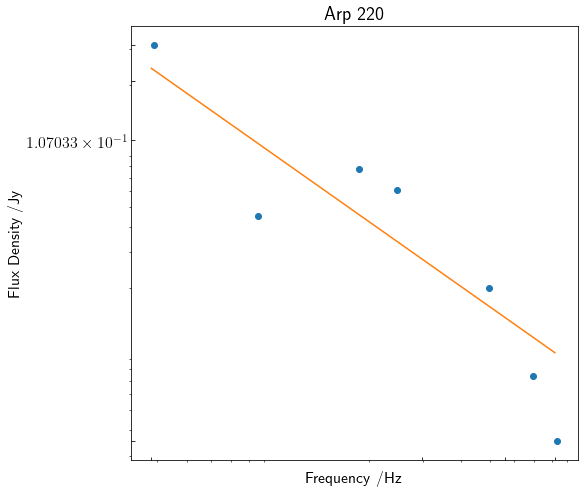

In [13]:
# Optimization
fit2 = optimize.fmin(penalty, [-31, 37.4, 2.9, 1.5], args=(frequencies_Arp, flux_densities_Arp, errors_Arp))
arp_fit = model1(frequencies_Arp, fit2)
print (fit2)

# Plotting:
x = np.logspace(np.log10(freq_range[0]),np.log10(freq_range[1]))

f, ax = plt.subplots(1, figsize=(8,8))
ax.plot(frequencies_Arp, flux_densities_Arp, 'o')
ax.plot(x, model1(x,fit2))
ax.set_xscale('log')
ax.set_xticks(np.linspace(*freq_range, 4))
ax.set_yscale('log')
ax.set_yticks(np.linspace(*flux_range, 4))
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
ax.set_title('Arp 220')
ax.set_ylabel('Flux Density /Jy')
ax.set_xlabel('Frequency /Hz')
f.show()

In [14]:
# Emcee run for Arp 220 model

ndim = 4
nwalk = ndim*2
nburn = 1000
nmain = 5000

# Random starting points
p0 = np.zeros((nwalk, ndim))
for i in range(nwalk):
    p0[i] = fit2 + np.random.uniform(low=-0.05, high=0.05, size=4)

    
sampler = emcee.EnsembleSampler(nwalk, ndim, lnprob, args=(frequencies_Arp, flux_densities_Arp, errors_Arp))

# Burn-in run
try:
    pos,prob,state = sampler.run_mcmc(p0, nburn)
    
    sampler.reset()

    # Main run
    res = sampler.run_mcmc(pos, nmain)
    samples = sampler.chain.reshape((-1,ndim))

    # plot the individual parameters for model
    f, ax = plt.subplots(ndim, 1, figsize=(10, 10))
    for idim in range(ndim):
        for iwalk in range(nwalk):
            ax[idim].plot(sampler.chain[iwalk,:,idim])
        ax[idim].set_xlabel('step')
    ax[0].set_ylabel(r'$L$')
    ax[1].set_ylabel(r'$T$')
    ax[2].set_ylabel(r'$\alpha$')
    ax[3].set_ylabel(r'$\beta$')
    f.tight_layout()
    f.show()

    # Plot corner plot
    f = corner.corner(samples, show_titles=True, labels=(r'$L$', r'$T$', r'$\alpha$', r'$\beta$'))
    f.show()
except RuntimeError:
    print("encountered '{}'".format(RuntimeError))



emcee: Exception while calling your likelihood function:
  params: [  3.31922287 -18.89332091   0.99932215  -0.69163086]
  args: (array([3.88876e+13, 8.61228e+13, 1.85276e+14, 2.47374e+14, 4.94748e+14,
       6.93258e+14, 8.33742e+14]), array([0.314  , 0.0453 , 0.0772 , 0.0612 , 0.02   , 0.0074 , 0.00355]), array([0.0289  , 0.00417 , 0.00202 , 0.00282 , 0.000922, 0.0033  ,
       0.000509]))
  kwargs: {}
  exception:
encountered '<class 'RuntimeError'>'


<ipython-input-5-2a3f8c4c25a0>:4: RuntimeWarning: invalid value encountered in double_scalars
  return 3 + beta - ((10**nu)*h/(k*T))*np.exp(h*(10**nu)/(k*T))/(np.exp(h*(10**nu)/(k*T))-1) + alpha
Traceback (most recent call last):
  File "c:\users\antho\appdata\local\programs\python\python38-32\lib\site-packages\emcee\ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-5-2a3f8c4c25a0>", line 23, in lnprob
    return -0.5*penalty(param, freq, flux, error)
  File "<ipython-input-5-2a3f8c4c25a0>", line 20, in penalty
    return np.sum((model1(freq, param)-flux)**2/error**2)
  File "<ipython-input-5-2a3f8c4c25a0>", line 8, in model1
    nu_prime = optimize.newton(limit, 13, args=(T, alpha, beta))
  File "c:\users\antho\appdata\local\programs\python\python38-32\lib\site-packages\scipy\optimize\zeros.py", line 363, in newton
    raise RuntimeError(msg)
RuntimeError: Failed to converge after 50 iterations, value is nan.


# New Dataset: Lower Infrared (Microwaves/Radar)

In [19]:
f_ARP220_list, omitted_numbers_2 = get_in_key('ARP220', [295, 285, 270, 262, 253, 249, 221])

frequencies_Arp = np.array(f_ARP220_list["frequency"])
flux_densities_Arp = np.array(f_ARP220_list["flux_density"])
errors_Arp = np.array(f_ARP220_list["uncertainty"])

freq_range = (np.max(frequencies_Arp), np.min(frequencies_Arp))
flux_range = (np.max(flux_densities_Arp), np.min(flux_densities_Arp))

print(frequencies_Arp)
print(flux_densities_Arp)
print(errors_Arp)

# Accounting for redshift
frequencies_Arp = (1 + 0.018)*np.array(frequencies_Arp)

[1.40e+11 2.16e+11 2.31e+11 2.40e+11 2.73e+11 3.45e+11 8.57e+11]
[ 0.0528  0.16    0.34    0.243   0.07    0.49   10.5   ]
[8.00e-04 3.20e-02 8.00e-02 3.00e-03 1.05e-02 4.90e-02 3.30e+00]


[-50.31460481   2.21508331  12.23930183   3.84539463]


<ipython-input-22-8cc8199166e3>:21: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  f.show()


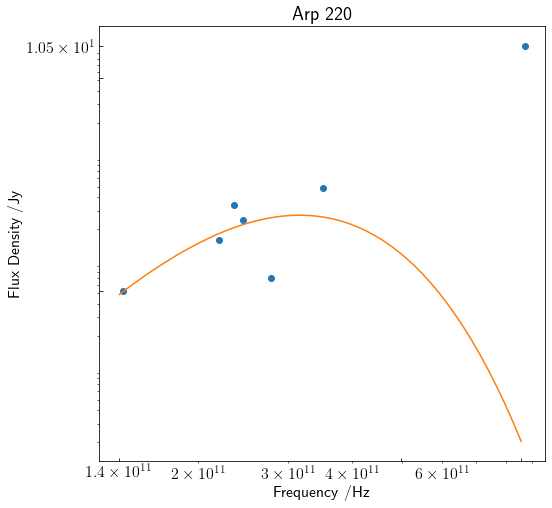

In [22]:
# Optimization
fit2 = optimize.fmin(penalty, [-31, 37.4, 2.9, 1.5], args=(frequencies_Arp, flux_densities_Arp, errors_Arp))
arp_fit = model1(frequencies_Arp, fit2)
print (fit2)

# Plotting:
x = np.logspace(np.log10(freq_range[0]),np.log10(freq_range[1]))

f, ax = plt.subplots(1, figsize=(8,8))
ax.plot(frequencies_Arp, flux_densities_Arp, 'o')
ax.plot(x, model1(x,fit2))
ax.set_xscale('log')
ax.set_xticks(np.linspace(*freq_range, 3))
ax.set_yscale('log')
ax.set_yticks(np.linspace(*flux_range, 3))
ax.tick_params(axis="y",direction="in")
ax.tick_params(axis="x",direction="in")
ax.set_title('Arp 220')
ax.set_ylabel('Flux Density /Jy')
ax.set_xlabel('Frequency /Hz')
f.show()

In [21]:
# Emcee run for Arp 220 model

ndim = 4
nwalk = ndim*2
nburn = 1000
nmain = 5000

# Random starting points
p0 = np.zeros((nwalk, ndim))
for i in range(nwalk):
    p0[i] = fit2 + np.random.uniform(low=-0.05, high=0.05, size=4)

    
sampler = emcee.EnsembleSampler(nwalk, ndim, lnprob, args=(frequencies_Arp, flux_densities_Arp, errors_Arp))

# Burn-in run
try:
    pos,prob,state = sampler.run_mcmc(p0, nburn)
    
    sampler.reset()

    # Main run
    res = sampler.run_mcmc(pos, nmain)
    samples = sampler.chain.reshape((-1,ndim))

    # plot the individual parameters for model
    f, ax = plt.subplots(ndim, 1, figsize=(10, 10))
    for idim in range(ndim):
        for iwalk in range(nwalk):
            ax[idim].plot(sampler.chain[iwalk,:,idim])
        ax[idim].set_xlabel('step')
    ax[0].set_ylabel(r'$L$')
    ax[1].set_ylabel(r'$T$')
    ax[2].set_ylabel(r'$\alpha$')
    ax[3].set_ylabel(r'$\beta$')
    f.tight_layout()
    f.show()

    # Plot corner plot
    f = corner.corner(samples, show_titles=True, labels=(r'$L$', r'$T$', r'$\alpha$', r'$\beta$'))
    f.show()
except RuntimeError:
    print("encountered '{}'".format(RuntimeError))

emcee: Exception while calling your likelihood function:
  params: [-55.93887339   1.99227103  -8.92825806   4.36238   ]
  args: (array([1.42520e+11, 2.19888e+11, 2.35158e+11, 2.44320e+11, 2.77914e+11,
       3.51210e+11, 8.72426e+11]), array([ 0.0528,  0.16  ,  0.34  ,  0.243 ,  0.07  ,  0.49  , 10.5   ]), array([8.00e-04, 3.20e-02, 8.00e-02, 3.00e-03, 1.05e-02, 4.90e-02,
       3.30e+00]))
  kwargs: {}
  exception:
encountered '<class 'RuntimeError'>'


<ipython-input-5-2a3f8c4c25a0>:4: RuntimeWarning: divide by zero encountered in double_scalars
  return 3 + beta - ((10**nu)*h/(k*T))*np.exp(h*(10**nu)/(k*T))/(np.exp(h*(10**nu)/(k*T))-1) + alpha
<ipython-input-5-2a3f8c4c25a0>:4: RuntimeWarning: invalid value encountered in double_scalars
  return 3 + beta - ((10**nu)*h/(k*T))*np.exp(h*(10**nu)/(k*T))/(np.exp(h*(10**nu)/(k*T))-1) + alpha
Traceback (most recent call last):
  File "c:\users\antho\appdata\local\programs\python\python38-32\lib\site-packages\emcee\ensemble.py", line 545, in __call__
    return self.f(x, *self.args, **self.kwargs)
  File "<ipython-input-5-2a3f8c4c25a0>", line 23, in lnprob
    return -0.5*penalty(param, freq, flux, error)
  File "<ipython-input-5-2a3f8c4c25a0>", line 20, in penalty
    return np.sum((model1(freq, param)-flux)**2/error**2)
  File "<ipython-input-5-2a3f8c4c25a0>", line 8, in model1
    nu_prime = optimize.newton(limit, 13, args=(T, alpha, beta))
  File "c:\users\antho\appdata\local\programs\py